In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

In [2]:
BSinfo = pd.read_csv('Dataset/BSinfo.csv')
CLdata = pd.read_csv('Dataset/CLdata.csv')
ECdata = pd.read_csv('Dataset/ECdata.csv')
sample_submission = pd.read_csv('Dataset/SampleSubmission.csv')

In [3]:
# Define the WMAPE function
def wmape(y_true, y_pred):
    weights = np.abs(y_true)
    wmape = np.sum(np.abs(y_true - y_pred) / weights) * 100.0 / np.sum(weights)
    return wmape

In [4]:
BSinfo.head()

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [5]:
CLdata.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


<Axes: xlabel='Time'>

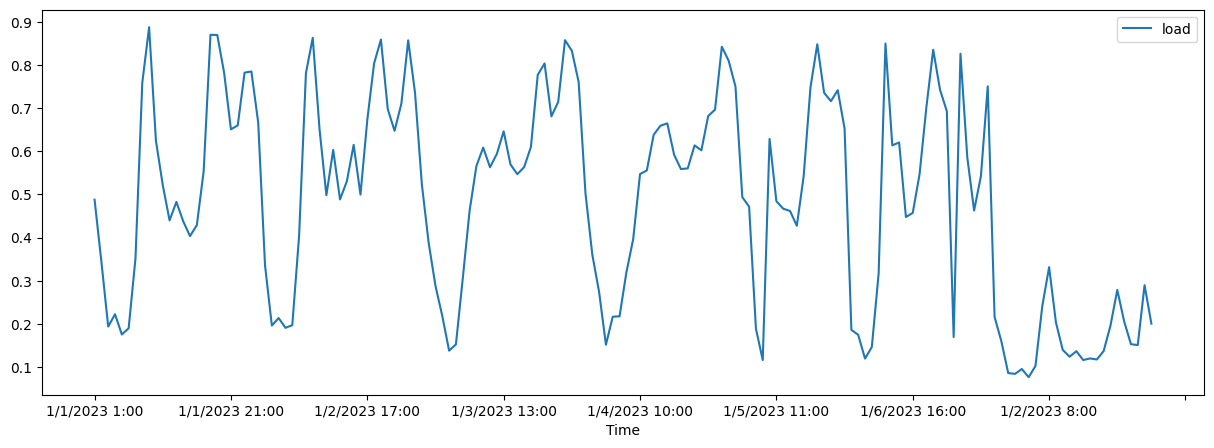

In [11]:
# plot the CLdata Time and load data for BS = 'B_0'

    
CLdata[CLdata['BS'] == 'B_0'].plot(x='Time', y='load', figsize=(15, 5))


In [27]:
#change the CLdata Time to datetime format
CLdata['Time'] = pd.to_datetime(CLdata['Time'])
CLdata['Time'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 125575 entries, 0 to 125574
Series name: Time
Non-Null Count   Dtype         
--------------   -----         
125575 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 981.2 KB


In [31]:
# create new dataframe with Time and load data for each base stations (group base station and Time)
CLdata_grouped = CLdata[['BS','Time','load']].groupby(['BS', 'Time']).sum().reset_index()
CLdata_grouped.head()

,BS,Time,load
0,B_0,2023-01-01 01:00:00,0.487936
1,B_0,2023-01-01 02:00:00,0.344468
2,B_0,2023-01-01 03:00:00,0.193766
3,B_0,2023-01-01 04:00:00,0.222383
4,B_0,2023-01-01 05:00:00,0.175436


In [16]:
mergedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118768 entries, 0 to 118767
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   BS      118768 non-null  object 
 1   Time    118768 non-null  object 
 2   load    118768 non-null  float64
 3   Energy  92629 non-null   float64
dtypes: float64(2), object(2)
memory usage: 3.6+ MB


In [24]:
CLdata_grouped.head()

,BS,Time,load
0,B_0,1/1/2023 10:00,0.624745
1,B_0,1/1/2023 11:00,0.522096
2,B_0,1/1/2023 12:00,0.439968
3,B_0,1/1/2023 13:00,0.482723
4,B_0,1/1/2023 14:00,0.437926


In [49]:
# merge the CLdata_grouped and ECdata using left join
mergedData = pd.merge(CLdata_grouped, ECdata, on=('Time','BS'), how='left')
mergedData.head()

,BS,Time,load,Energy
0,B_0,2023-01-01 01:00:00,0.487936,64.275037
1,B_0,2023-01-01 02:00:00,0.344468,55.904335
2,B_0,2023-01-01 03:00:00,0.193766,57.698057
3,B_0,2023-01-01 04:00:00,0.222383,55.156951
4,B_0,2023-01-01 05:00:00,0.175436,56.053812


In [20]:
sample_submission.head()

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1
2,2023-01-01 12:00:00,B_0,NaN,1
3,2023-01-01 13:00:00,B_0,NaN,1
4,2023-01-01 23:00:00,B_0,NaN,1


In [28]:
3 # change the data format of the Time column in the sample_submission dataframe
sample_submission['Time'] = pd.to_datetime(sample_submission['Time'])
sample_submission.head()

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1
2,2023-01-01 12:00:00,B_0,NaN,1
3,2023-01-01 13:00:00,B_0,NaN,1
4,2023-01-01 23:00:00,B_0,NaN,1


Index(['BS', 'load', 'Energy'], dtype='object')

In [23]:
ECdata.head()

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [29]:
# change the data format of the Time column in the mergedData dataframe
ECdata['Time'] = pd.to_datetime(ECdata['Time'])
ECdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    92629 non-null  datetime64[ns]
 1   BS      92629 non-null  object        
 2   Energy  92629 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.1+ MB


In [52]:
mergedData.head(10)

,BS,load,Energy
Time,,,
2023-01-01 01:00:00,B_0,0.487936,64.275037
2023-01-01 02:00:00,B_0,0.344468,55.904335
2023-01-01 03:00:00,B_0,0.193766,57.698057
2023-01-01 04:00:00,B_0,0.222383,55.156951
2023-01-01 05:00:00,B_0,0.175436,56.053812
2023-01-01 06:00:00,B_0,0.189872,NaN
2023-01-01 07:00:00,B_0,0.351585,82.959641
2023-01-01 08:00:00,B_0,0.759298,91.031390
2023-01-01 09:00:00,B_0,0.887798,78.176383


In [39]:
# multiply the load column values by 100
mergedData['load'] = mergedData['load'] * 100

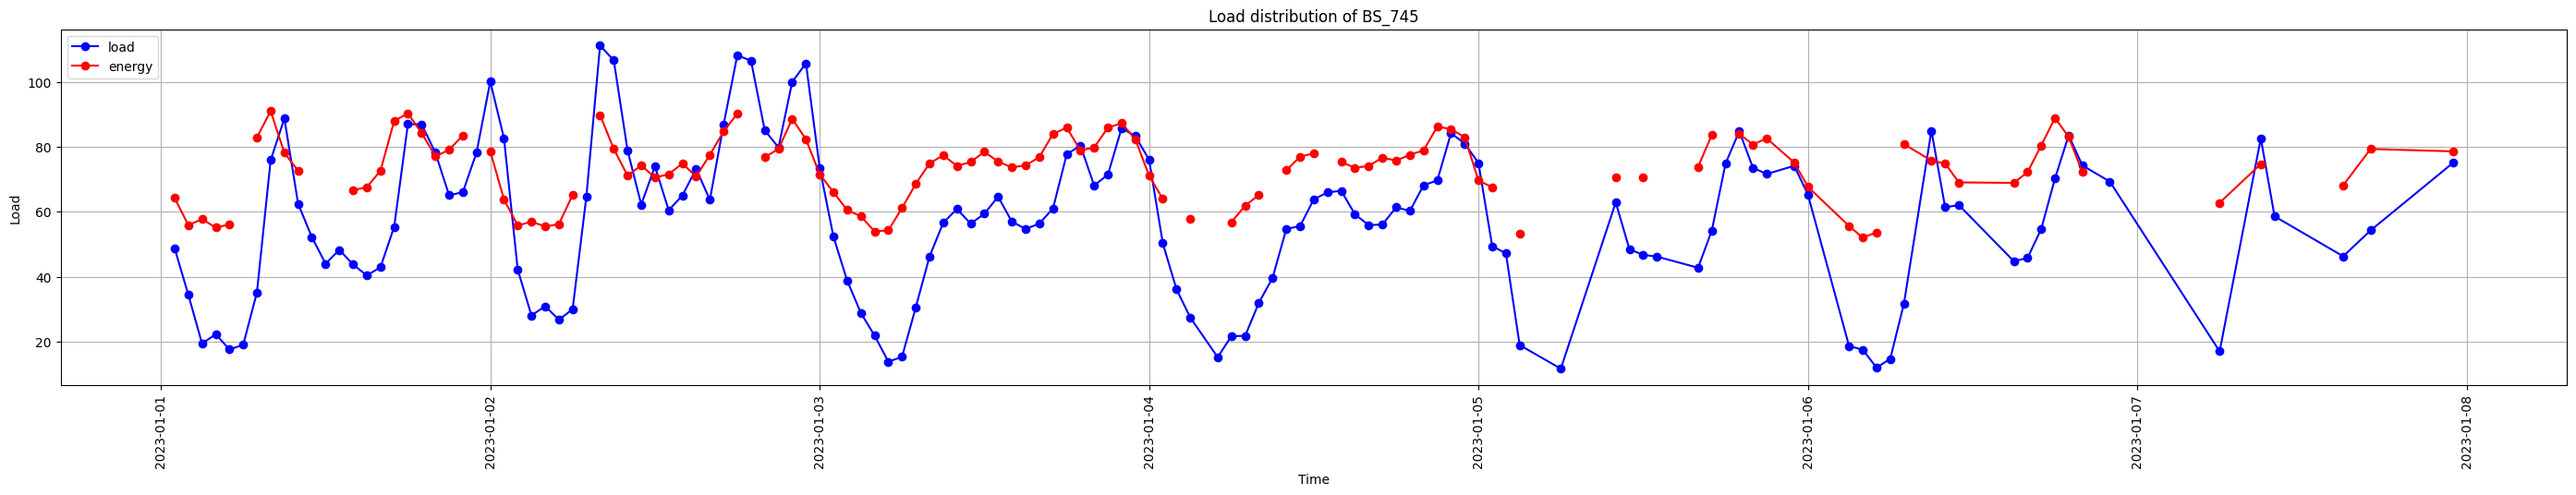

In [40]:
import matplotlib.pyplot as plt

BS1data = mergedData[mergedData['BS'] == 'B_0']
plt.figure(figsize=(35, 5))
plt.plot(BS1data['Time'],BS1data['load'], marker='o', linestyle='-', color='b', label='load')
plt.plot(BS1data['Time'],BS1data['Energy'], marker='o', linestyle='-', color='r', label='energy')

plt.legend(loc='upper left')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Load')
plt.grid(True)
plt.title('Load distribution of BS_745')
plt.show()

In [48]:
# set the Time column as the index of the mergedData dataframe
mergedData.set_index('Time', inplace=True)
mergedData.head()

KeyError: "None of ['Time'] are in the columns"

<Axes: xlabel='Time'>

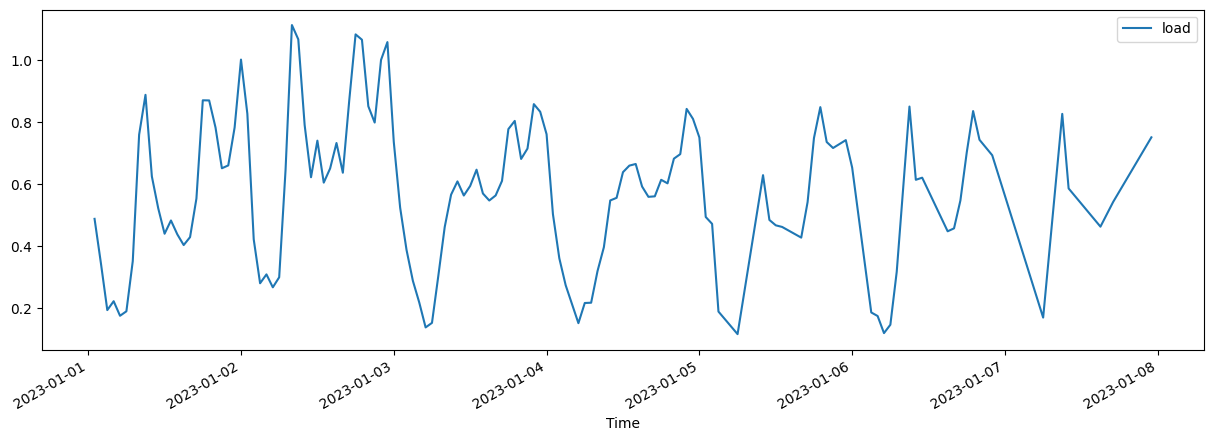

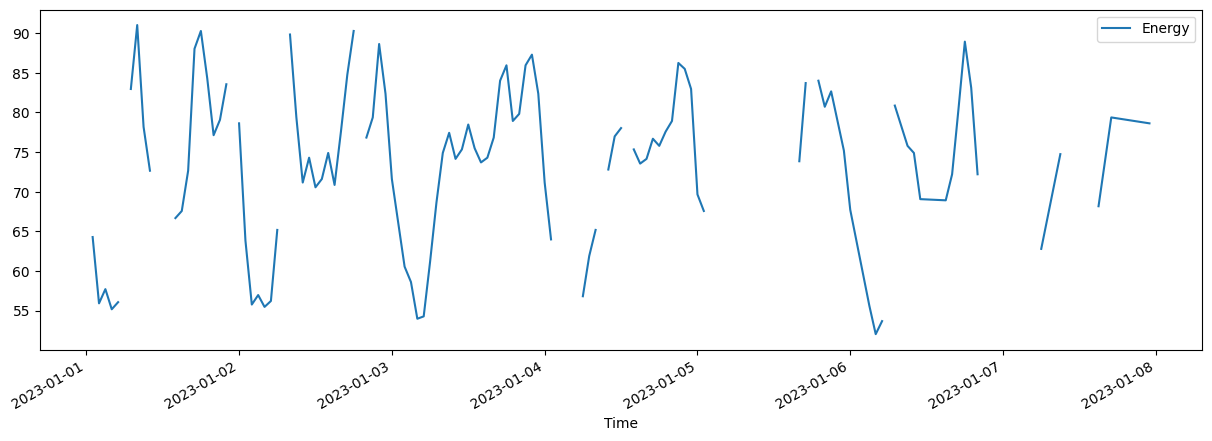

In [37]:
# plot the mergedData Time and load data for BS = 'B_0' 
mergedData[mergedData['BS'] == 'B_0'].plot(x='Time', y='load', figsize=(15, 5))
# plot th eenegy consumption data for BS = 'B_0' in same plot
mergedData[mergedData['BS'] == 'B_0'].plot(x='Time', y='Energy', figsize=(15, 5))


In [58]:
mergedData.head(10)

,BS,load,Energy,energy_imputed
Time,,,,
2023-01-01 01:00:00,B_0,0.487936,64.275037,64.275037
2023-01-01 02:00:00,B_0,0.344468,55.904335,55.904335
2023-01-01 03:00:00,B_0,0.193766,57.698057,57.698057
2023-01-01 04:00:00,B_0,0.222383,55.156951,55.156951
2023-01-01 05:00:00,B_0,0.175436,56.053812,56.053812
2023-01-01 06:00:00,B_0,0.189872,NaN,NaN
2023-01-01 07:00:00,B_0,0.351585,82.959641,82.959641
2023-01-01 08:00:00,B_0,0.759298,91.031390,91.031390
2023-01-01 09:00:00,B_0,0.887798,78.176383,78.176383


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Load your merged dataframe with columns 'Time', 'load', 'BS', and 'Energy'
# Replace this with your actual merged dataframe
# mergedData['Time'] = pd.to_datetime(mergedData['Time'])
# mergedData = mergedData.set_index('Time')

# Fill missing energy values using ARIMA for each base station and load
def impute_energy_arima_with_bs(load, energy, bs):
    energy_imputed = energy.copy()
    for i, value in enumerate(energy_imputed):
        if np.isnan(value):
            bs_value = bs.iloc[i]
            load_value = load.iloc[i]
            
            # Select energy data for training for the specific base station and load
            energy_train = energy_imputed[(bs == bs_value) & (load == load_value)].iloc[:i]
            
            if len(energy_train) < 5:
                # Not enough data to estimate ARIMA, skip imputation
                continue
            
            try:
                # Fit ARIMA model with a simpler order
                model = ARIMA(energy_train, order=(2,1,0))  # Adjust order as needed
                model_fit = model.fit()
                
                # Forecast missing energy value
                forecast = model_fit.forecast(steps=1)
                energy_imputed.iloc[i] = forecast[0]
            except Exception as e:
                print(f"Error imputing energy at index {i}: {e}")
    return energy_imputed

# Apply imputation function and assign results to a new column
imputed_energy = impute_energy_arima_with_bs(mergedData['load'], mergedData['Energy'], mergedData['BS'])
mergedData['energy_imputed'] = imputed_energy

# Print the dataframe with imputed energy values
print(mergedData)


# Apply imputation function and assign results to a new column
mergedData['energy_imputed'] = impute_energy_arima_with_bs(mergedData['load'], mergedData['Energy'], mergedData['BS'])

# Print the dataframe with imputed energy values
print(mergedData)


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Load your dataframe with datetime, load, and energy columns
# Replace this with your actual dataframe
data = pd.read_csv('your_data.csv')
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

# Fill missing energy values using ARIMA
def impute_energy_arima(load, energy):
    energy_imputed = energy.copy()
    for i, value in enumerate(energy_imputed):
        if np.isnan(value):
            # Select load data for training
            load_train = load.iloc[:i]
            energy_train = energy_imputed.iloc[:i]

            # Fit ARIMA model
            model = ARIMA(energy_train, order=(5,1,0))  # Example order, tune as needed
            model_fit = model.fit()

            # Forecast missing energy value
            forecast = model_fit.forecast(steps=1)
            energy_imputed.iloc[i] = forecast[0]
    return energy_imputed

data['energy_imputed'] = impute_energy_arima(data['load'], data['energy'])

# Print the dataframe with imputed energy values
print(data)


In [33]:
# merge sample_submission and merged_data
testData = pd.merge(sample_submission, mergedData, on=('Time','BS'), how='left')
testData.head()


,Time,BS,Energy_x,w,load,Energy_y
0,2023-01-01 06:00:00,B_0,NaN,1,0.189872,NaN
1,2023-01-01 11:00:00,B_0,NaN,1,0.522096,NaN
2,2023-01-01 12:00:00,B_0,NaN,1,0.439968,NaN
3,2023-01-01 13:00:00,B_0,NaN,1,0.482723,NaN
4,2023-01-01 23:00:00,B_0,NaN,1,0.782511,NaN


In [34]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26139 entries, 0 to 26138
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Time      26139 non-null  datetime64[ns]
 1   BS        26139 non-null  object        
 2   Energy_x  0 non-null      float64       
 3   w         26139 non-null  int64         
 4   load      26139 non-null  float64       
 5   Energy_y  0 non-null      float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 1.2+ MB


In [19]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26139 entries, 0 to 26138
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    26139 non-null  object 
 1   BS      26139 non-null  object 
 2   Energy  0 non-null      float64
 3   w       26139 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 817.0+ KB


In [9]:
ECdata.head()

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [7]:
ECdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    92629 non-null  object 
 1   BS      92629 non-null  object 
 2   Energy  92629 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.1+ MB


In [8]:
CLdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125575 entries, 0 to 125574
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time      125575 non-null  object 
 1   BS        125575 non-null  object 
 2   CellName  125575 non-null  object 
 3   load      125575 non-null  float64
 4   ESMode1   125575 non-null  float64
 5   ESMode2   125575 non-null  float64
 6   ESMode3   125575 non-null  float64
 7   ESMode4   125575 non-null  int64  
 8   ESMode5   125575 non-null  float64
 9   ESMode6   125575 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 9.6+ MB
